In [488]:
#Les modules utilisés pour le projet

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy as sp
import seaborn as sns
import matplotlib

# Pour les barres de chargement
from tqdm.notebook import tqdm, trange

# Setting plotting style
sns.set_style("darkgrid")
matplotlib.rcParams.update({'font.size': 20})

import warnings
warnings.filterwarnings('ignore')

## Cas de débiteurs indépendants et de défaut à maturité:

Par estimation de p = P(W < mean)



Valeur théorique de p = P(W<W_0) =  0.009283105350599749
Probabilité estimée par Monte Carlo : p_MC =  0.00918
Intervale de confiance MC : [ 0.008588892031692594 , 0.009771107968307408 ]
Probabilité estimée par IS : p_IS =  0.009307774674948428
intervale de confiance IS [ 0.009213002644130995 , 0.009402546705765862 ]

Méthode naïve MC



Première méthode d'Importance Sampling


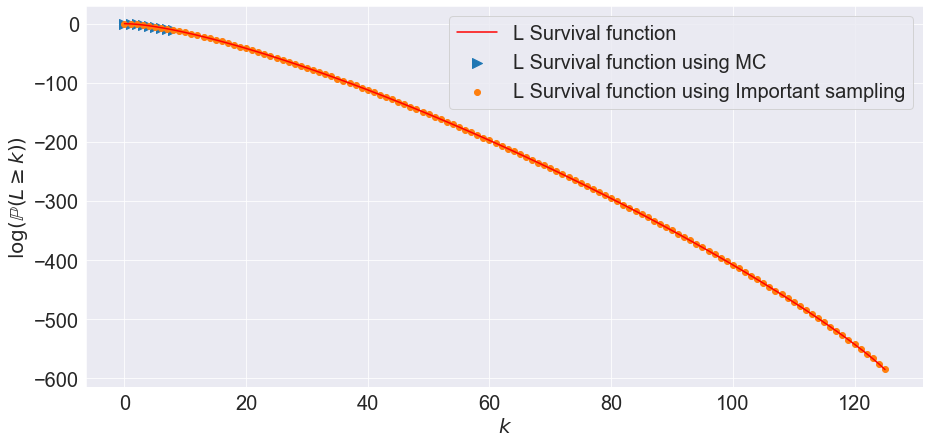

<Figure size 1080x504 with 0 Axes>

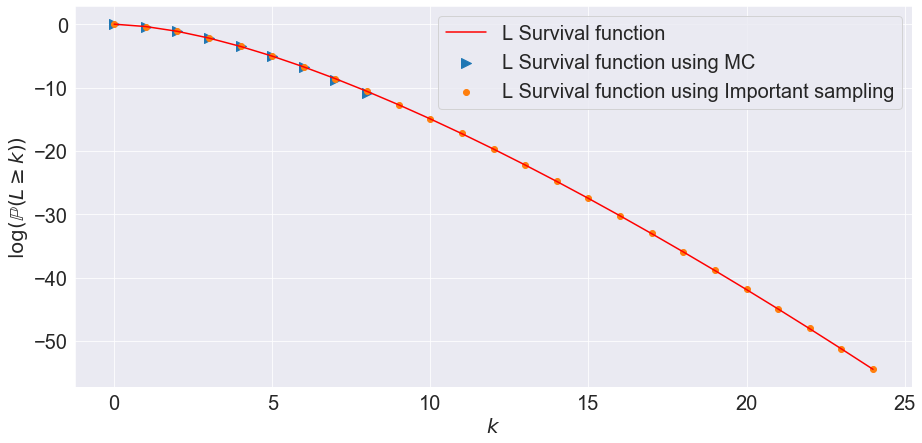

In [489]:
'''
Ce code permet pour une valeur de N, B et sigma d'appliquer la méthode d'Exponetial Twisting. Il applique aussi une estimation
de Monte Carlo Naïve pour estimer les probabilités P(L >= k)
'''
N = 125 # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
M = int(1e5)
B = 36
mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
q = sps.norm.ppf(0.975)

# Valeurs théoriques des probabilités -------------------------------------------------------

p = sps.norm.cdf(mean)
espace = np.arange(-0.1,N)
fBin = sps.binom.sf(espace,N,p)
espace = espace + 0.1

# Calcul de la fonction de survie par estimation de la probabilité P(Z<M(B,sigma)) ---------------------------------------------------------
Y = np.random.normal(0,1,size=M)
p_MC = np.mean(Y<mean)
p_es = np.mean(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))
ratio=[0.0]

probas_IS=[]
probas_MC = []
print("Par estimation de p = P(W < mean)")
pbar = tqdm(total=N)
for k in range(N+1):
    proba1 = 0.0
    proba2 = 0.0
    for i in range(k,N+1):
        proba1+= p_es**i*(1-p_es)**(N-i)*sp.special.binom(N,i)
        proba2+= p_MC**i*(1-p_MC)**(N-i)*sp.special.binom(N,i)
    probas_IS.append(proba1)
    probas_MC.append(proba2)
    pbar.update(1)
pbar.close()
print("Valeur théorique de p = P(W<W_0) = ",p)
print("Probabilité estimée par Monte Carlo : p_MC = ", p_MC)
std_MC = np.std(Y<mean)
print("Intervale de confiance MC : [",p_MC-q*std_MC/(np.sqrt(M)),',',p_MC+q*std_MC/(np.sqrt(M)),']')
print("Probabilité estimée par IS : p_IS = ", p_es)
std_IS = np.std(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))
print("intervale de confiance IS [",p_es-q*std_IS/(np.sqrt(M)),',',p_es+q*std_IS/(np.sqrt(M)),']\n')

# Méthode naïve MC  -------------------------------------------------------------------------

P = []
vect_std_MC = []
L = np.random.binomial(N,p_es,size=M)
print("Méthode naïve MC")
pbar = tqdm(total=N)
for k in range(N+1): 
    P.append(np.mean(L >= k))
    vect_std_MC.append(np.mean(L >= k)*q*(1/np.sqrt(M)))
    pbar.update(1)
pbar.close()

# Première méthode d'Importance Sampling / Exponential twisting -----------------------------------------------------

P_IS = [1.0]
print("Première méthode d'Importance Sampling")
pbar = tqdm(total=N)
PH = [1.0]
PD = [1.0]
#boxes = []
for k in range(0,N):
    teta = np.log(((k/N)/(1-(k/N)))*((1-p_es)/(p_es)))
    if k <= N*p_es:
        teta = 0
    Psi = N*np.log(1+p_es*(np.exp(teta)-1))
    L = np.random.binomial(N,p_es*np.exp(teta)/(1+p_es*(np.exp(teta)-1)),size=M)
    res = (L > k)*np.exp(-teta*L+Psi)
    mu = np.mean(res)
    P_IS.append(mu)
    si = np.std(res)*q*(1/np.sqrt(M))
    ratio.append(si/mu)
    PH.append(mu+si)
    PD.append(mu-si)
    pbar.update(1)
pbar.close()
#plt.boxplot(boxes)
#plt.show()

# Préparation des np.arrays -----------------------------------------------------------------


#permet de calculer où s'arrête l'estimatio de MC naive
Stop_MC = 0
while  Stop_MC < N and P[Stop_MC] != 0:
    Stop_MC+=1


# Calcul du premier k non calculé par MC 
P = np.array(P)
P_IS = np.array(P_IS)
probas_IS = np.array(probas_IS)
probas_MC = np.array(probas_MC)
PH = np.array(PH)
PD = np.array(PD)

h = np.min(P_IS[P_IS>0])
PD2 = []
for i in range(len(PD)):
    if PD[i] <= 0.0:
        PD2.append(h)
    else : 
        PD2.append(PD[i])

# Affichage des courbes ---------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.scatter(range(N+1),np.log(P),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(N+1),np.log(P_IS),label="L Survival function using Important sampling")
plt.plot(espace,np.log(fBin),'r-',label="L Survival function")
#plt.fill_between(range(N+1), np.log(PD2), np.log(PH), alpha=0.2, 
#                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
limit = max(2*N//10,10)

h = np.min(P_IS[:limit][P_IS[:limit]>0])
PD3 = []
for i in range(limit):
    if PD[i] <= 0.0:
        PD3.append(h)
    else : 
        PD3.append(PD[i])
        
plt.figure(figsize=(15,7))
plt.scatter(range(limit),np.log(P[:limit]),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(limit),np.log(P_IS[:limit]),label="L Survival function using Important sampling")
plt.plot(espace[:limit],np.log(fBin[:limit]),'r-',label="L Survival function")
#plt.fill_between(range(limit), np.log(PD3[:limit]), np.log(PH[:limit]), alpha=0.2, 
#                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

In [490]:
#Affichage des Intervalle de confiance pour tout k dans [0,N]
i = 0
while i < N+1 and P_IS[i] != 0.0:
    print("Estimation par IS de P(L>=",i,') =',P_IS[i])
    print("Estimation par MC de P(L>=",i,') =',P[i])
    print('Intervalle de confiance MC : Ic(',str(i),') = [',vect_std_MC[i],']')
    print('Intervalle de confiance : Ic(',str(i),') = [',(PD[i]-PH[i])/2,']\n')
    i+=1

Estimation par IS de P(L>= 0 ) = 1.0
Estimation par MC de P(L>= 0 ) = 1.0
Intervalle de confiance MC : Ic( 0 ) = [ 0.006197950323045615 ]
Intervalle de confiance : Ic( 0 ) = [ 0.0 ]

Estimation par IS de P(L>= 1 ) = 0.69013
Estimation par MC de P(L>= 1 ) = 0.68975
Intervalle de confiance MC : Ic( 1 ) = [ 0.004275036235320713 ]
Intervalle de confiance : Ic( 1 ) = [ -0.0028661790048077895 ]

Estimation par IS de P(L>= 2 ) = 0.32541
Estimation par MC de P(L>= 2 ) = 0.32462
Intervalle de confiance MC : Ic( 2 ) = [ 0.0020119786338670675 ]
Intervalle de confiance : Ic( 2 ) = [ -0.0029039122445096432 ]

Estimation par IS de P(L>= 3 ) = 0.11261397408168985
Estimation par MC de P(L>= 3 ) = 0.11218
Intervalle de confiance MC : Ic( 3 ) = [ 0.0006952860672392572 ]
Intervalle de confiance : Ic( 3 ) = [ -0.0010987712115677062 ]

Estimation par IS de P(L>= 4 ) = 0.0299118918063667
Estimation par MC de P(L>= 4 ) = 0.02973
Intervalle de confiance MC : Ic( 4 ) = [ 0.00018426506310414612 ]
Intervalle de 

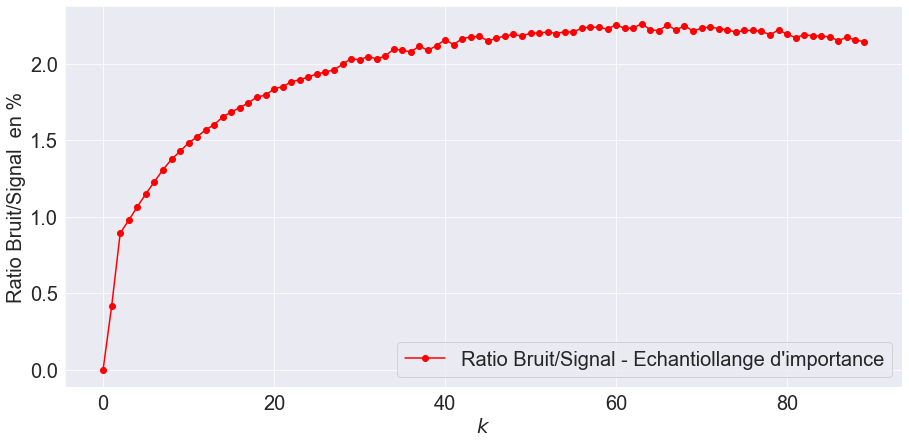

In [491]:
# Affiche le ratio bruit/signal
    
plt.figure(figsize=(15,7))
plt.plot(range(90),np.array(ratio[:90])*100,'ro-',label="Ratio Bruit/Signal - Echantiollange d'importance")
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'Ratio Bruit/Signal  en %')
plt.show()

In [492]:
def erreur_Expo(k,S0,N,M,B):
    '''
    Cette fonction permet de calculer l'erreur effectué par un l'Exponential Twisting dans le cas où le paramètre p serait 
    lui aussi à prendre dans un intervalle de confiance.
    
    '''
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    q = sps.norm.ppf(0.975)
    Y = np.random.normal(0,1,size=M)
    p_es = np.mean(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))
    si = np.std(np.exp((mean)**2/2 - mean*(Y+mean))*(Y+mean<mean))*q*1/np.sqrt(M)
    H = 100
    values = []

    #boxes = []
    p = p_es
    teta = np.log(((k/N)*(1-(k/N)))*((1-p)/(p)))
    if k <= N*p:
        teta = 0
    Psi = N*np.log(1+p*(np.exp(teta)-1))
    L = np.random.binomial(N,p_es*np.exp(teta)/(1+p*(np.exp(teta)-1)),size=M)
    res = (L > k)*np.exp(-teta*L+Psi)
    mu = np.mean(res)
    p_estime = mu
    
    for j in range(H+1):
        P_IS_2 = [1.0]
        PH_2 = [1.0]
        PD_2 = [1.0]
        #boxes = []
        p = p_es+(j/H)*si
        teta = np.log(((k/N)*(1-(k/N)))*((1-p)/(p)))
        if k <= N*p:
            teta = 0
        Psi = N*np.log(1+p*(np.exp(teta)-1))
        L = np.random.binomial(N,p*np.exp(teta)/(1+p*(np.exp(teta)-1)),size=M)
        res = (L > k)*np.exp(-teta*L+Psi)
        mu = np.mean(res)
        P_IS_2.append(mu)
        si = np.std(res)*q*(1/np.sqrt(M))
        values.append(mu+si)
        values.append(mu-si)
    for j in range(1,H+1):
        P_IS_2 = [1.0]
        PH_2 = [1.0]
        PD_2 = [1.0]
        #boxes = []
        p = p_es-(j/H)*si
        teta = np.log(((k/N)*(1-(k/N)))*((1-p)/(p)))
        if k <= N*p:
            teta = 0
        Psi = N*np.log(1+p*(np.exp(teta)-1))
        L = np.random.binomial(N,p*np.exp(teta)/(1+p*(np.exp(teta)-1)),size=M)
        res = (L > k)*np.exp(-teta*L+Psi)
        mu = np.mean(res)
        P_IS_2.append(mu)
        si = np.std(res)*q*(1/np.sqrt(M))
        values.append(mu+si)
        values.append(mu-si)
    p_min = np.min([np.min([values[i],values2[i],values2_1[i],values2_2[i]]) for i in range(H)])
    p_max = np.max([np.max([values[i],values2[i],values2_1[i],values2_2[i]]) for i in range(H)])
    return np.min([p_estime-p_min,p_max-p_estime]/p_estime)


Par estimation de p = P(W < mean)


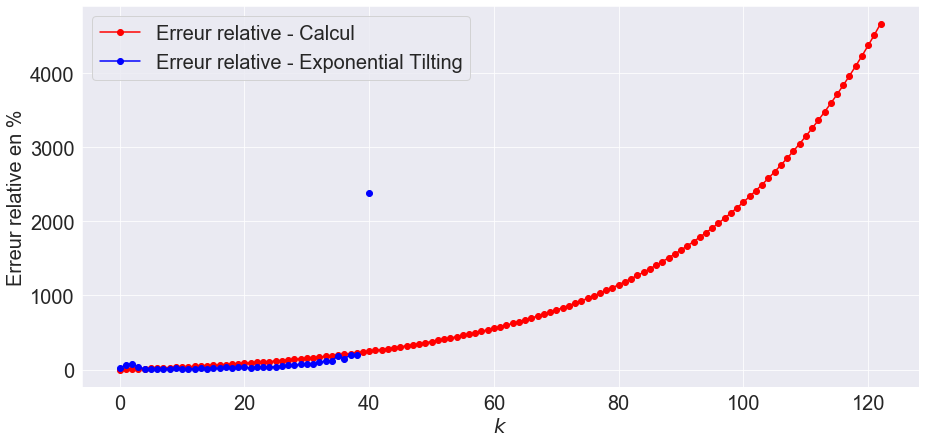

In [493]:
'''
Calcul et affiche le ratio bruit/signal de la méthode de calcul en utilisant une estimation de P(Z<M(B,sigma))
et le bruit potentiel approché en utilisant cette estimation dans pour l'Exponential Tilting
'''
N = 125 # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
sigma = 0.4
M = int(1e4)
B = 36

stop = 0
ratio = []
while stop < N+1 and P_IS[stop] != 0.0:
    stop+=1
stop -=3
pbar = tqdm(total=stop)
for j in range(stop):
    ratio.append(erreur_Expo(j,S0,N,M,B))
    pbar.update(1)
pbar.close()


probas_IS=[1.0]
probas_MC = [1.0]
print("Par estimation de p = P(W < mean)")
pbar = tqdm(total=N)
PD_MC = [1.0]
PD_IS = [1.0]
PH_MC = [1.0]
PH_IS = [1.0]
ratio_MC=[0.0]
ratio_IS=[0.0]
p_MC_1 = p_MC-1.96*std_MC/(np.sqrt(M))
p_MC_2 = p_MC+1.96*std_MC/(np.sqrt(M))
p_IS_1 = p_es-1.96*std_IS/(np.sqrt(M))
p_IS_2 = p_es+1.96*std_IS/(np.sqrt(M))
for k in range(1,N+1):
    proba1 = 0.0
    proba2 = 0.0
    proba1_MC = 0.0
    proba2_MC = 0.0
    proba1_IS = 0.0
    proba2_IS = 0.0
    for i in range(k,N+1):
        proba1+= p_es**i*(1-p_es)**(N-i)*sp.special.binom(N,i)
        proba2+= p_MC**i*(1-p_MC)**(N-i)*sp.special.binom(N,i)
        proba1_MC+= p_MC_1**i*(1-p_MC_1)**(N-i)*sp.special.binom(N,i)
        proba2_MC+= p_MC_2**i*(1-p_MC_2)**(N-i)*sp.special.binom(N,i)
        proba1_IS+= p_IS_1**i*(1-p_IS_1)**(N-i)*sp.special.binom(N,i)
        proba2_IS+= p_IS_2**i*(1-p_IS_2)**(N-i)*sp.special.binom(N,i)
    probas_IS.append(proba1)
    probas_MC.append(proba2)
    PD_MC.append(proba1_MC)
    PD_IS.append(proba1_IS)
    PH_MC.append(proba2_MC)
    PH_IS.append(proba2_IS)
    ratio_MC.append(np.max([proba2-proba1_MC,proba2_MC-proba2]/proba2))
    ratio_IS.append(np.max([proba1-proba1_IS,proba2_IS-proba1]/proba1))
    pbar.update(1)
pbar.close()


plt.figure(figsize=(15,7))
plt.plot(range(stop),np.array(ratio_IS[:stop])*100,'ro-',label="Erreur relative - Calcul")
plt.plot(range(stop),np.array(ratio)*100,'bo-',label="Erreur relative - Exponential Tilting")
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'Erreur relative en %')
plt.show()

In [494]:
'''
Etant donnée un tableau P de probabilité et d'une valeur x, calcule un valeur approché de theta*_x
'''
def teta_optimal(P,x):
    teta = 0
    eps = 0.00001
    r = 0
    nmax = (1e6)
    norm = 1
    while norm > eps and r < nmax:
        H = np.sum((1-P)*P*np.exp(teta)/((1-P+P*np.exp(teta))*(1-P+P*np.exp(teta))))
        G = np.sum(P*np.exp(teta)/(1-P+P*np.exp(teta)))-x
        teta = teta - 0.1*(G/H)
        norm = np.abs(G)
        r+=1
    return teta

In [495]:
#Premier test de la fonction teta_optimal qui calcul le paramètre teta par méthode de Newton

print(teta_optimal(np.array([0.1]*10),2))
print(np.log(9*0.25)) # Nous savons que sous cette configuration teta_opt = np.log[((x/N)/(1-x/N))*(q/p)] avec q = 1-p 

0.8109246132411142
0.8109302162163288


In [496]:
def p_k(B,S0,sigma):
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    p = sps.norm.cdf(mean)
    return p

In [497]:
#Définit le produit de convolution entre deux loi sur [0,len(loi)-1]
def produitConvolution(loi1,loi2):
    espace = [i for i in range(len(loi1)+len(loi2)-1)]
    loi3 = [0 for e in espace]
    for k in espace:
        proba = 0
        for i in range(len(loi1)):
            if (k-i)>= 0 and (k-i)<len(loi2):
                loi3[k] += loi1[i]*loi2[k-i]
    return loi3

In [498]:
'''
Calcul la distribution de 
'''
def distributions(B,N):
    N2 = N//5
    sigma = np.array([0.2,0.25,0.3,0.35,0.5])
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    P = sps.norm.cdf(mean)
    espace = np.arange(-0.1,N2)
    fBin = sps.binom.sf(espace,N2,P[0])
    for i in range(1,5):
        fBin = produitConvolution(fBin,sps.binom.sf(espace,N2,P[i]))
    return fBin

Méthode naïve MC



Première méthode d'Importance Sampling


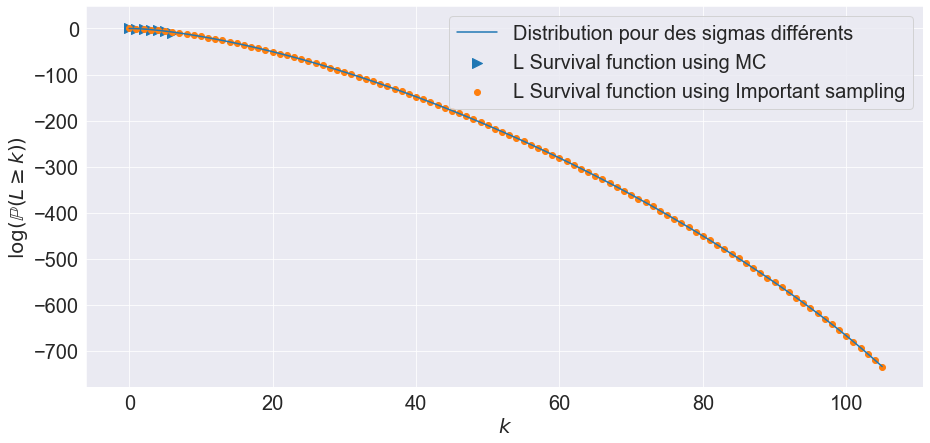

<Figure size 1080x504 with 0 Axes>

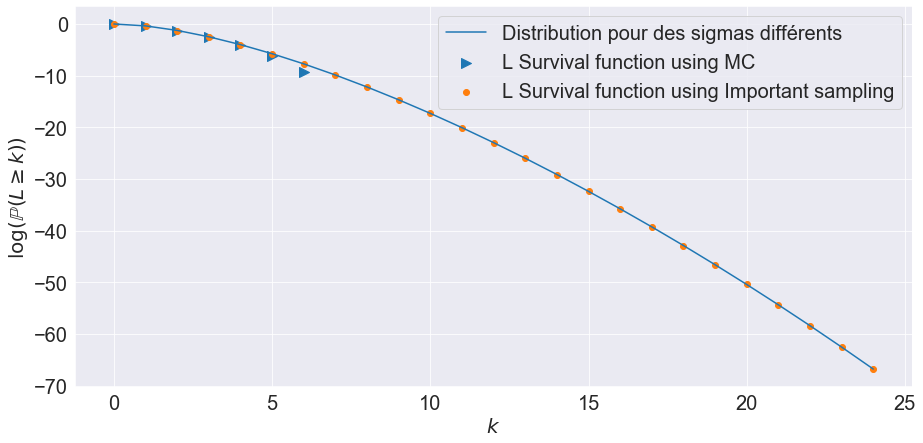

In [499]:
N = 125 # Nombre entreprise
S0 = 100   # Valeur initiale des entreprises 
M = int(1e4)
B = 36

result = distributions(B,N)
q = sps.norm.ppf(0.975)

# Méthode naïve MC  -------------------------------------------------------------------------
sigmas = np.array([0.2,0.25,0.3,0.35,0.5])
P = []
vect_std_MC_2 = []
L = np.array([0]*M)
for i in range(len(sigmas)):
    L += np.random.binomial(N//len(sigmas),p_k(B,S0,sigmas[i]),size=M) 
print("Méthode naïve MC")
pbar = tqdm(total=N)
for k in range(N+1): 
    P.append(np.mean(L >= k))
    vect_std_MC_2.append(np.std(L>=k)*q*(1/np.sqrt(M)))
    pbar.update(1)
pbar.close()

# Première méthode d'Importance Sampling-----------------------------------------------------

# tenter petites perturbations autour de 0 d'abord
P_IS = [1.0]
ratio_2 = [0.0]
print("Première méthode d'Importance Sampling")
pbar = tqdm(total=N)
PH = [1.0]
PD = [1.0]
#boxes = []
for k in range(0,N):
    P_K = np.array([])
    for j in range(len(sigmas)):
        P_K = np.append(P_K,np.array([p_k(B,S0,sigmas[j])]*(N//len(sigmas))))
    if k <= np.sum(P_K):
        teta = 0
    else : 
        teta = teta_optimal(P_K,k)
    Psi = np.sum(np.log(1+P_K*(np.exp(teta)-1)))
    L = np.array([0]*M)
    for i in range(len(sigmas)):
        temp = p_k(B,S0,sigmas[i])
        temp = temp*np.exp(teta)/(1+temp*(np.exp(teta)-1))
        L += np.random.binomial(N//len(sigmas),temp,size=M) 
    res = (L > k)*np.exp(-teta*L+Psi)
    mu = np.mean(res)
    P_IS.append(mu)
    si = np.std(res)*q*(1/np.sqrt(M))
    ratio_2.append(si/mu)
    PH.append(mu+si)
    PD.append(mu-si)
    pbar.update(1)
pbar.close()
#plt.boxplot(boxes)
#plt.show()
# tenter petites perturbations autour de 0 d'abord
# Préparation des np.arrays -----------------------------------------------------------------

Stop_MC = 0
while  Stop_MC < N and P[Stop_MC] != 0:
    Stop_MC+=1


# Calcul du premier k non calculé par MC 
P = np.array(P)
P_IS = np.array(P_IS)
probas_IS = np.array(probas_IS)
probas_MC = np.array(probas_MC)
PH = np.array(PH)
PD = np.array(PD)

h = np.min(P_IS[P_IS>0])
PD2 = []
for i in range(len(PD)):
    if PD[i] <= 0.0:
        PD2.append(h)
    else : 
        PD2.append(PD[i])

# Affichage des courbes ---------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.plot(range(N+1),np.log(result),label="Distribution pour des sigmas différents")
plt.scatter(range(N+1),np.log(P),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(N+1),np.log(P_IS),label="L Survival function using Important sampling")
#plt.fill_between(range(N+1), np.log(PD2), np.log(PH), alpha=0.2, 
#                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
limit = min(max(2*N//10,10),N+1)

h = np.min(P_IS[:limit][P_IS[:limit]>0])
PD3 = []
for i in range(limit):
    if PD[i] <= 0.0:
        PD3.append(h)
    else : 
        PD3.append(PD[i])
        
plt.figure(figsize=(15,7))
plt.scatter(range(limit),np.log(P[:limit]),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(limit),np.log(P_IS[:limit]),label="L Survival function using Important sampling")
plt.plot(range(limit),np.log(result[:limit]),label="Distribution pour des sigmas différents")
#plt.fill_between(range(limit), np.log(PD3[:limit]), np.log(PH[:limit]), alpha=0.2, 
#                label="intervalle de confiance à 95% pour IS")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

In [500]:
i = 0
while i < N+1 and P_IS[i] != 0.0:
    print("Estimation par IS de P(L>=",i,') =',P_IS[i])
    print("Estimation par MC de P(L>=",i,') =',P[i])
    print('Intervalle de confiance MC : Ic(',str(i),') = [',vect_std_MC_2[i],']')
    print('Intervalle de confiance : Ic(',str(i),') = [',(PD[i]-PH[i])/2,']\n')
    i+=1

Estimation par IS de P(L>= 0 ) = 1.0
Estimation par MC de P(L>= 0 ) = 1.0
Intervalle de confiance MC : Ic( 0 ) = [ 0.0 ]
Intervalle de confiance : Ic( 0 ) = [ 0.0 ]

Estimation par IS de P(L>= 1 ) = 0.6445
Estimation par MC de P(L>= 1 ) = 0.6373
Intervalle de confiance MC : Ic( 1 ) = [ 0.009423100609255788 ]
Intervalle de confiance : Ic( 1 ) = [ -0.009381652757551429 ]

Estimation par IS de P(L>= 2 ) = 0.2709
Estimation par MC de P(L>= 2 ) = 0.2676
Intervalle de confiance MC : Ic( 2 ) = [ 0.008676914406734449 ]
Intervalle de confiance : Ic( 2 ) = [ -0.008710561324788035 ]

Estimation par IS de P(L>= 3 ) = 0.07764724925814379
Estimation par MC de P(L>= 3 ) = 0.0765
Intervalle de confiance MC : Ic( 3 ) = [ 0.005209514587748971 ]
Intervalle de confiance : Ic( 3 ) = [ -0.002483614888357563 ]

Estimation par IS de P(L>= 4 ) = 0.016969411593171762
Estimation par MC de P(L>= 4 ) = 0.0159
Intervalle de confiance MC : Ic( 4 ) = [ 0.0024516940274956194 ]
Intervalle de confiance : Ic( 4 ) = [ -0.

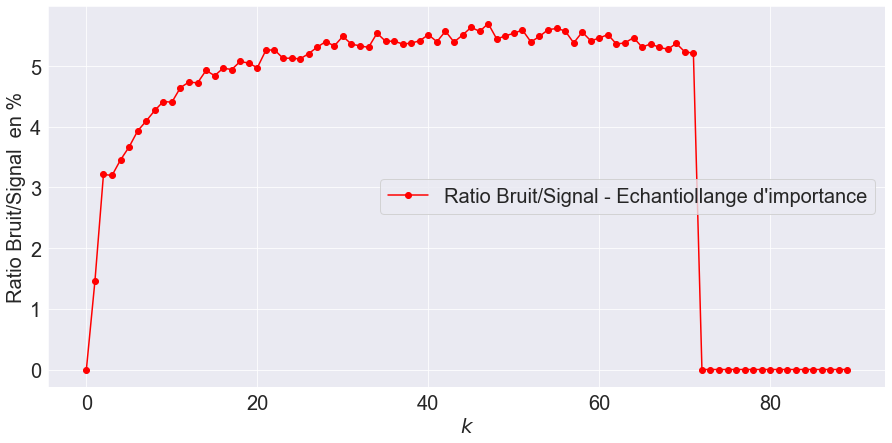

In [501]:
# Si l'on estime avoir bien calculer la probabilité de défaut d'une seule entreprise
    
plt.figure(figsize=(15,7))
plt.plot(range(90),np.array(ratio_2[:90])*100,'ro-',label="Ratio Bruit/Signal - Echantiollange d'importance")
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'Ratio Bruit/Signal  en %')
plt.show()

## Cas de débiteurs dépendants et de défaut à maturité:

In [502]:
def estime(z,rho,sigma,B,k,M,N):
    mean = (1/sigma)*np.log(B*np.exp(0.5*sigma*sigma)/S0)
    p = sps.norm.cdf((mean-np.sqrt(rho)*z)/np.sqrt(1-rho))
    teta = np.log(((k/N)/(1-(k/N)))*((1-p)/(p)))
    if k <= N*p:
        teta = 0
    Psi = N*np.log(1+p*(np.exp(teta)-1))
    L = np.random.binomial(N,p*np.exp(teta)/(1+p*(np.exp(teta)-1)),size=M)
    res = (L > k)*np.exp(-teta*L+Psi)
    return np.mean(res)

vestime = np.vectorize(estime)

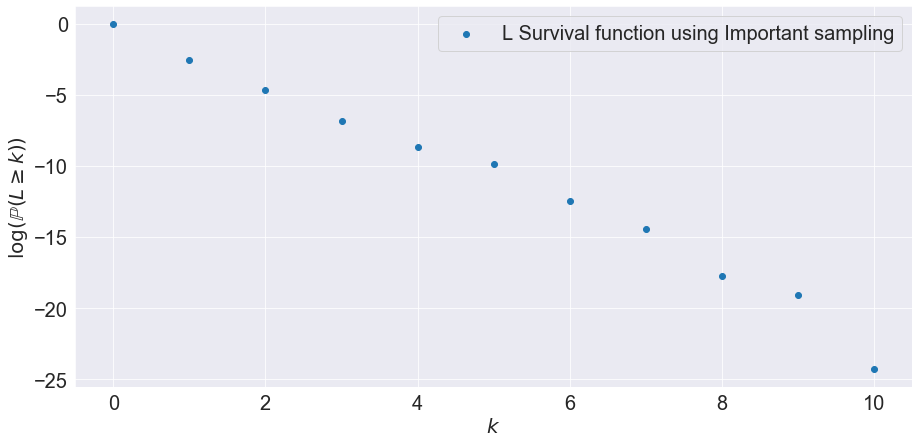

In [503]:
rho = 0.2
sigma = 0.4
B = 36
N = 10
M = int(1e4)

ratio = [0]
probas_ET = [1.0]

pbar = tqdm(total=N)
for k in range(N):
    W = vestime(np.random.normal(0,1,size=M),rho,sigma,B,k,1,N)
    probas_ET.append(np.mean(W))
    si = np.std(W)*1.96*(1/np.sqrt(M))
    ratio.append(si/probas_ET[-1])
    pbar.update(1)
pbar.close()

plt.figure(figsize=(15,7))
#plt.scatter(range(N+1),np.log(P),s=100,marker ='>',label="L Survival function using MC")
plt.scatter(range(N+1),np.log(probas_ET),label="L Survival function using Important sampling")
plt.xlabel(r'$k$')
plt.ylabel(r'$\log(\mathbb{P}(L \geq k))$')
plt.legend()
plt.show()

In [504]:
for i in range(N+1):
    print("P(L>= ",i,") = ",probas_ET[i])
    print("I_c = [",probas_ET[i]*(1-ratio[i]),',',probas_ET[i]*(1+ratio[i]),']')

P(L>=  0 ) =  1.0
I_c = [ 1.0 , 1.0 ]
P(L>=  1 ) =  0.0804
I_c = [ 0.07507053545894149 , 0.08572946454105851 ]
P(L>=  2 ) =  0.009573154228859841
I_c = [ 0.008392484790743063 , 0.010753823666976619 ]
P(L>=  3 ) =  0.0010336314622716432
I_c = [ 0.0007426412173470101 , 0.0013246217071962762 ]
P(L>=  4 ) =  0.0001778159892454949
I_c = [ 0.00010579135036021301 , 0.0002498406281307768 ]
P(L>=  5 ) =  5.298346104962803e-05
I_c = [ 1.4223901031731542e-05 , 9.174302106752452e-05 ]
P(L>=  6 ) =  3.837648861682974e-06
I_c = [ -1.791970334889325e-06 , 9.467268058255273e-06 ]
P(L>=  7 ) =  5.3122592993078e-07
I_c = [ 1.1467032840575444e-07 , 9.477815314558055e-07 ]
P(L>=  8 ) =  2.012241541284282e-08
I_c = [ -6.0034821623160575e-09 , 4.6248312988001694e-08 ]
P(L>=  9 ) =  5.291799738010616e-09
I_c = [ -2.1076529065837004e-09 , 1.2691252382604933e-08 ]
P(L>=  10 ) =  2.793286072346082e-11
I_c = [ -4.86475496355147e-12 , 6.073047641047311e-11 ]


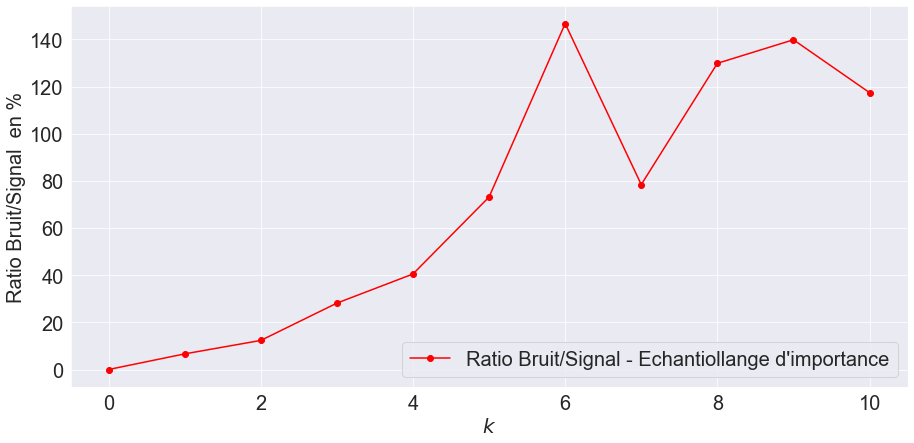

In [505]:
# Si l'on estime avoir bien calculer la probabilité de défaut d'une seule entreprise
    
plt.figure(figsize=(15,7))
plt.plot(range(0,N+1),np.array(ratio)*100,'ro-',label="Ratio Bruit/Signal - Echantiollange d'importance")
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'Ratio Bruit/Signal  en %')
plt.show()